In [1]:
%matplotlib notebook

import contextily as ctx
import geopandas as gpd
import pandas as pd
import rasterio
import folium
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt
import os
import numpy as np
import osmnx as ox

import typing as T
from itertools import zip_longest
from shapely.geometry import LineString

<IPython.core.display.Javascript object>


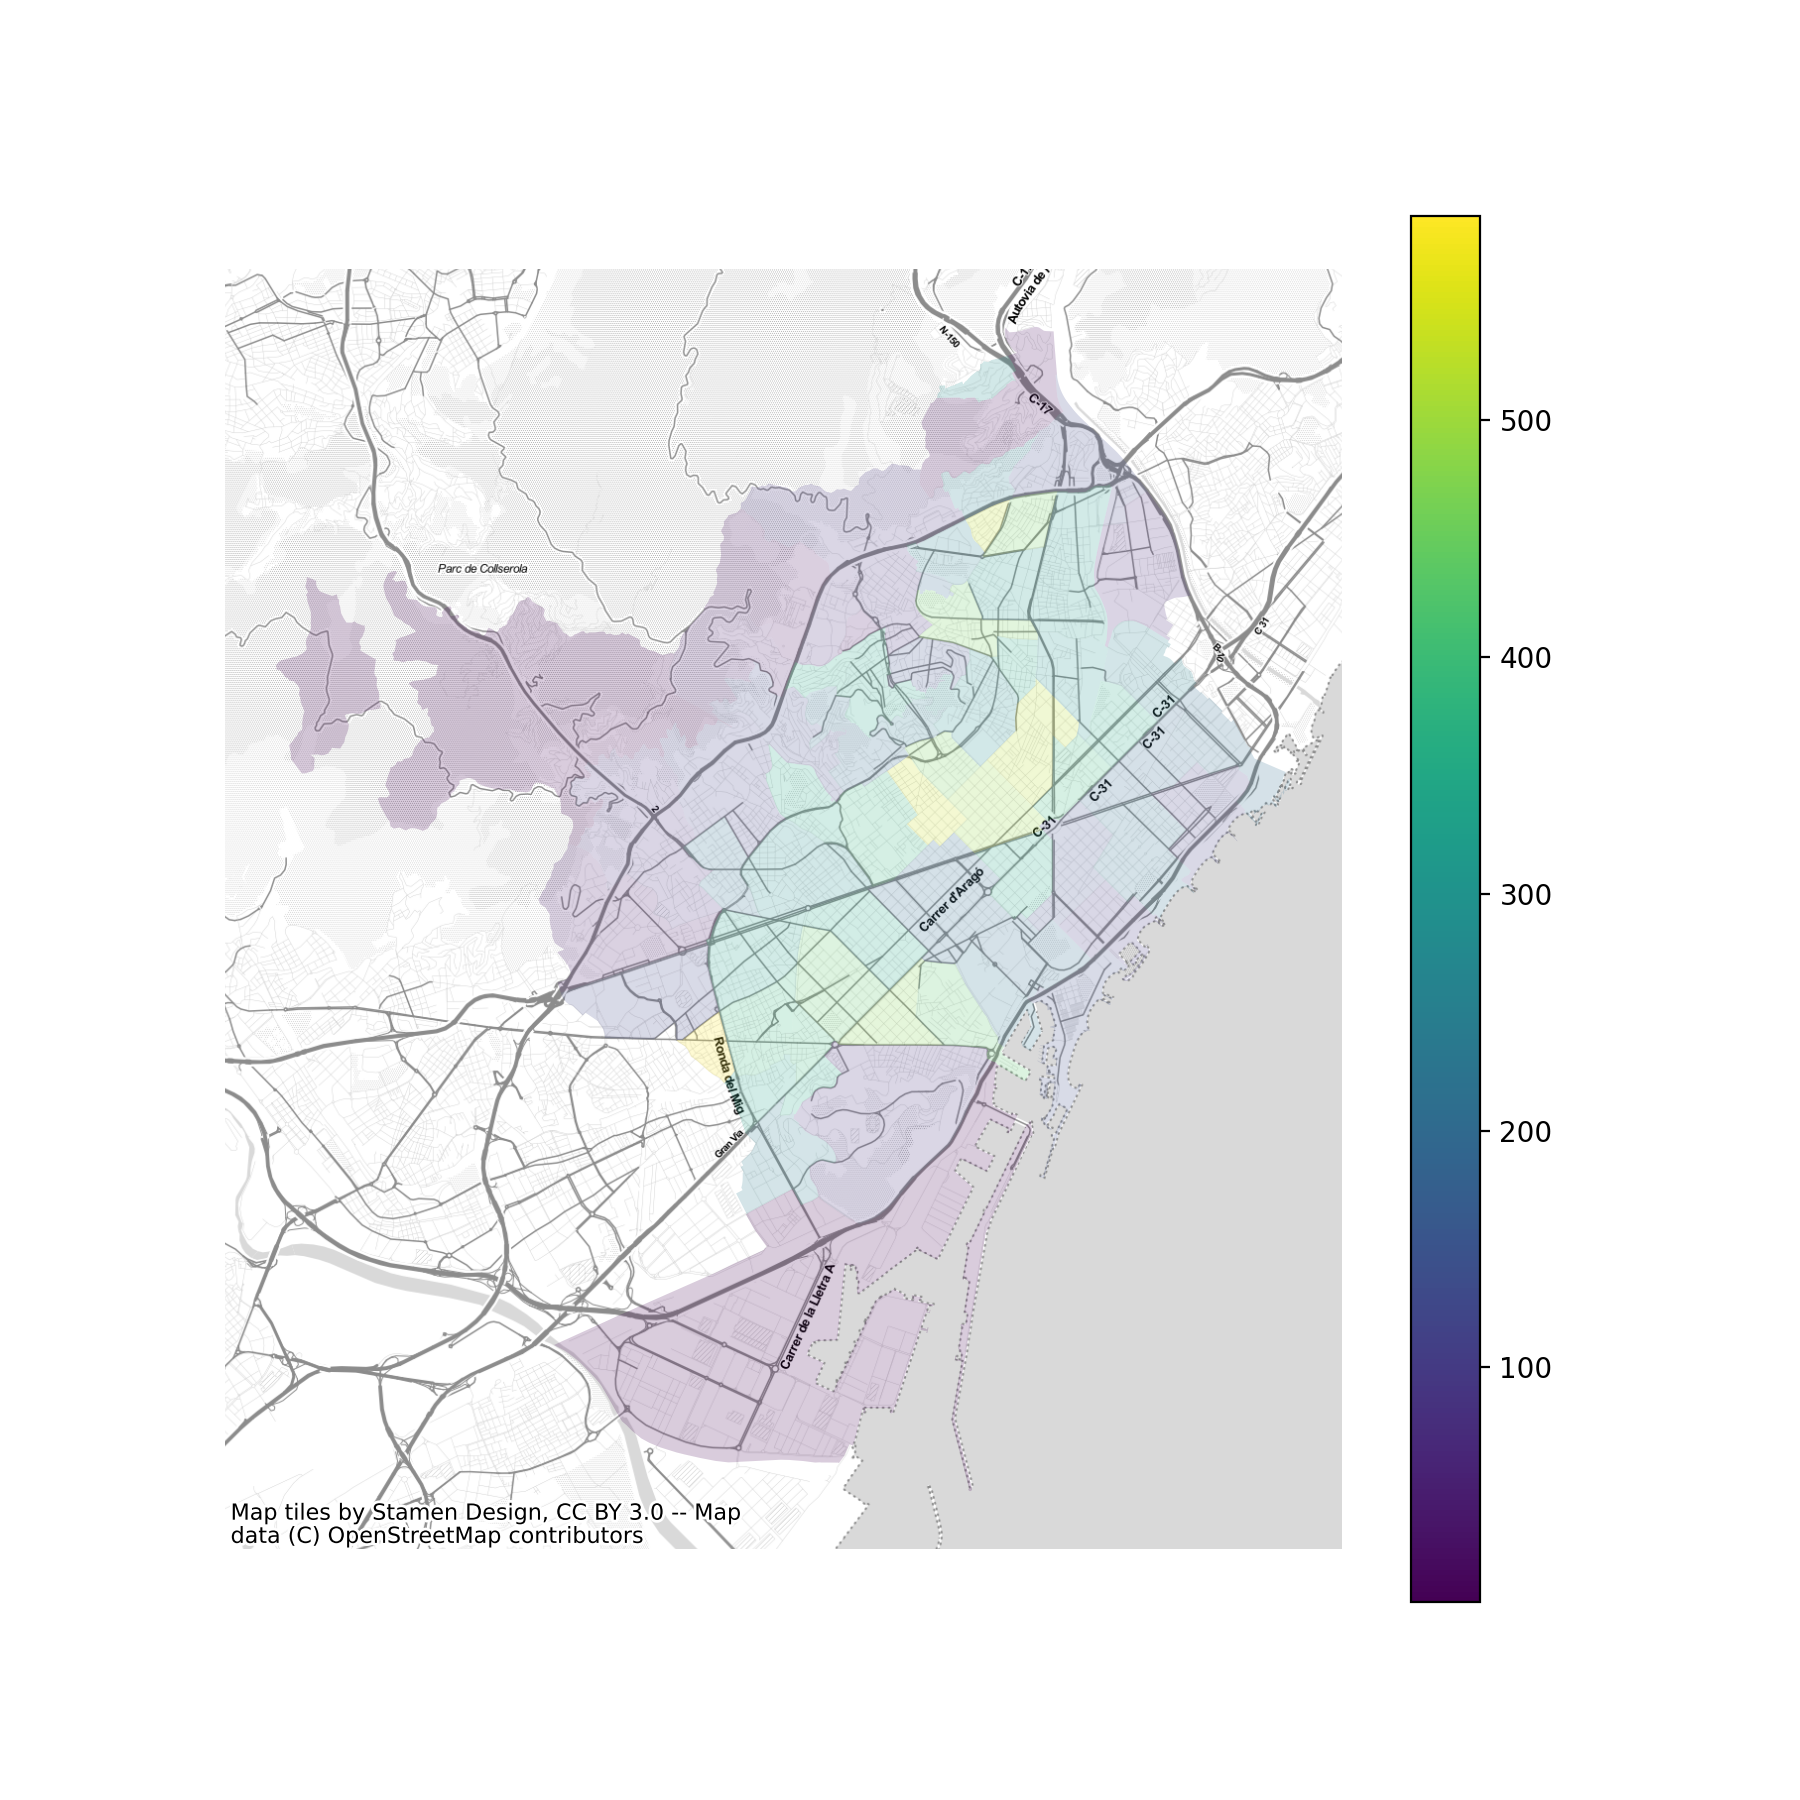

In [3]:
basedata = os.path.join('geodata','bcn')
blocks_fname = os.path.join(basedata, "barris.geojson")
barris = gpd.read_file(blocks_fname).to_crs(epsg=3857)
barris["Codi_Barri"] = barris["BARRI"].astype(np.int64)

density_fname = os.path.join(basedata, "2019_densitat.csv")
pop_den = pd.read_csv(density_fname)
pop_den = pop_den[["Codi_Barri", "Densitat (hab/ha)"]]
df = barris.merge(pop_den,on="Codi_Barri")
ax = df.plot(column='Densitat (hab/ha)', legend=True, alpha=0.2, figsize=(9,9));
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

In [4]:
amens_fname="geodata/bcn/amenities.pkl.gz"
if os.path.isfile(amens_fname):
    pois = pd.read_pickle(amens_fname)
else:
    place = "Barcelona, Spain" 
    tags = {'amenity': True}
    print("Downloading data, this might take a long time...")
    pois = ox.pois.pois_from_place(place, tags)
    pois.to_pickle(amens_fname, compression="gzip")
pois.head()


osmid                  geometry access           amenity  fee  \
30243885  30243885  POINT (2.15258 41.37537)    yes  parking_entrance  yes   
71643527  71643527  POINT (2.16496 41.38734)    NaN  parking_entrance  NaN   
82753755  82753755  POINT (2.15857 41.40251)    NaN          pharmacy  NaN   
82781675  82781675  POINT (2.15760 41.40311)    NaN          pharmacy  NaN   
82781676  82781676  POINT (2.15534 41.40395)    NaN          pharmacy  NaN   

              parking element_type  addr:city                 addr:full  \
30243885  underground         node        NaN                       NaN   
71643527          NaN         node        NaN                       NaN   
82753755          NaN         node  Barcelona  carrer Ramon I Cajal, 24   
82781675          NaN         node  Barcelona           carrer Verdi, 7   
82781676          NaN         node  Barcelona       carrer Asturies, 54   

         addr:housenumber  ... disused:building wall max_age rental  \
30243885              NaN  ...              NaN  NaN     NaN    NaN   
71643527              NaN  ...              NaN  NaN     NaN    NaN   
82753755               24  ...              NaN  NaN     NaN    NaN   
82781675                7  ...              NaN  NaN     NaN    NaN   
82781676               54  ...              NaN  NaN     NaN    NaN   

         theatre:type usage  org car_wash research garden:type  
30243885          NaN   NaN  NaN      NaN      NaN         NaN  
71643527          NaN   NaN  NaN      NaN      NaN         NaN  
82753755          NaN   NaN  NaN      NaN      NaN         NaN  
82781675          NaN   NaN  NaN      NaN      NaN         NaN  
82781676          NaN   NaN  NaN      NaN      NaN         NaN  

[5 rows x 550 columns]

In [23]:
# view just the banks
banks = pois[pois['amenity']=='bank'].dropna(axis=1, how='any').to_crs(epsg=3857)
hospitals = pois[pois['amenity'].isin(["hospital", "healthcare", "clinic"])].dropna(axis=1, how='any').to_crs(epsg=3857)
schools = pois[pois['amenity'].isin(["school primary education",'school'])].dropna(axis=1, how='any').to_crs(epsg=3857)
supermarkets = pois[pois['amenity'].isin(['supermarket',"market","marketplace"])].dropna(axis=1, how='any').to_crs(epsg=3857)
pharmacies = pois[pois['amenity']=='pharmacy'].dropna(axis=1, how='any').to_crs(epsg=3857)
eatings = pois[pois['amenity'].isin(["bar","restaurant","cafe"])].dropna(axis=1, how='any').to_crs(epsg=3857)
#print(len(banks), len(hospitals), len(schools), len(supermarkets), len(pharmacies))
#set(pois["amenity"].dropna())

<IPython.core.display.Javascript object>


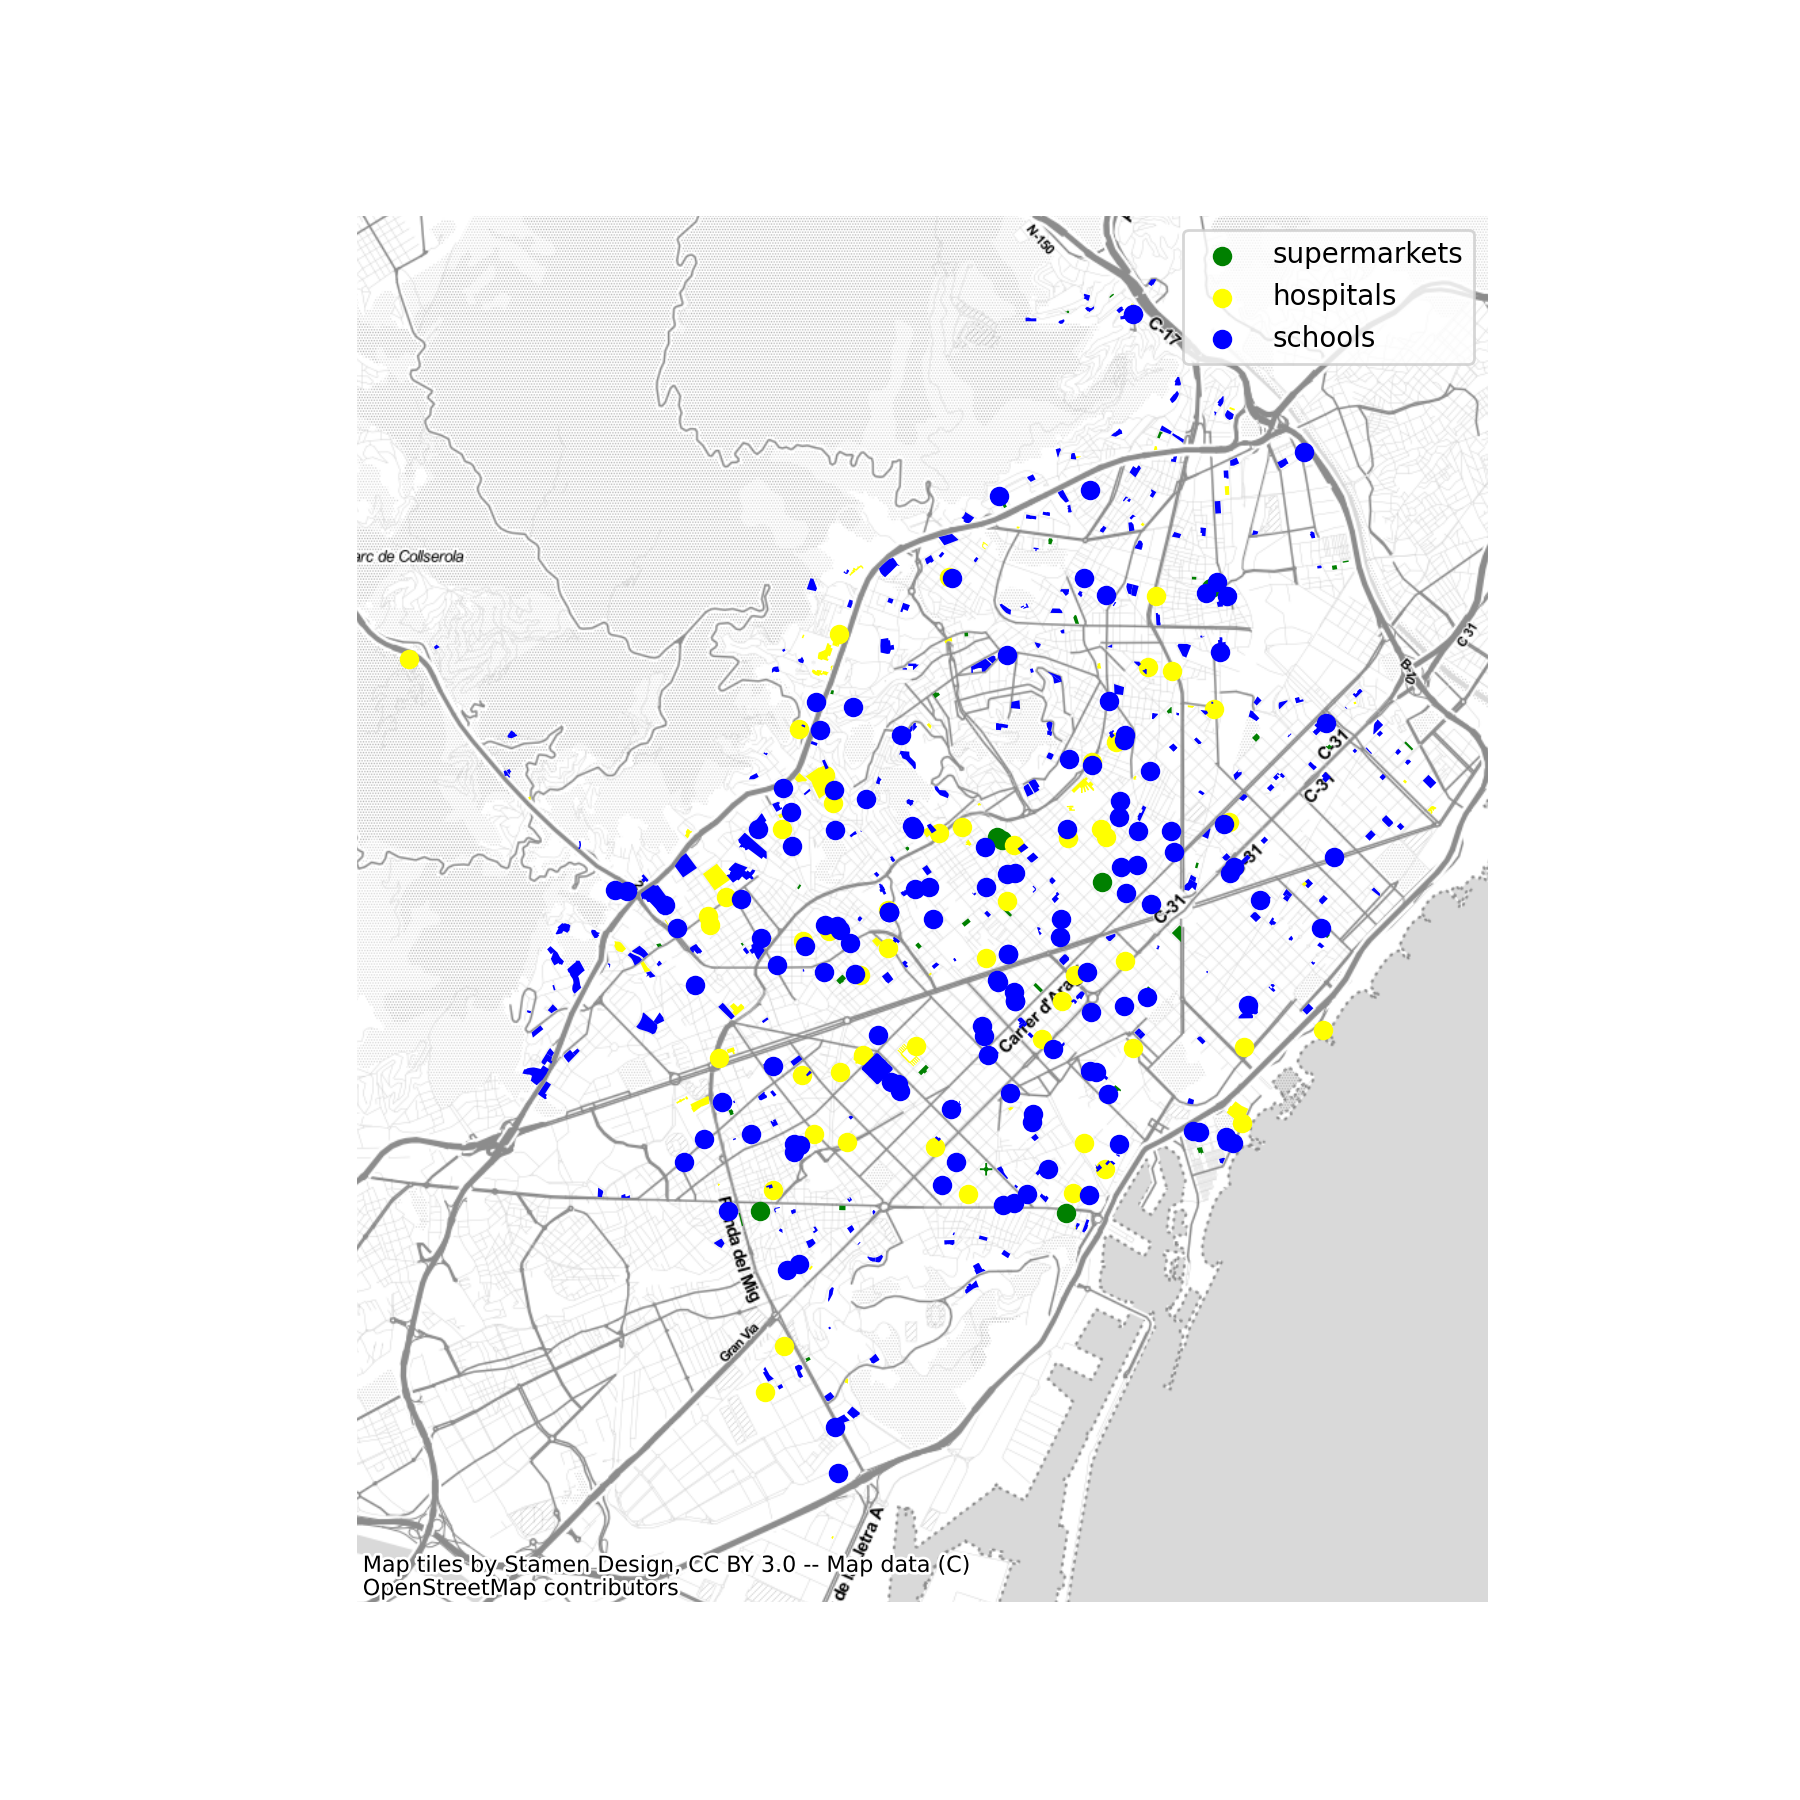

In [24]:
ax = supermarkets.plot(color="green", label="supermarkets", figsize=(9,9))
hospitals.plot(ax=ax, color="yellow", label="hospitals")
schools.plot(ax=ax, color="blue", label="schools")
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
plt.legend()
ax.set_axis_off()


<IPython.core.display.Javascript object>


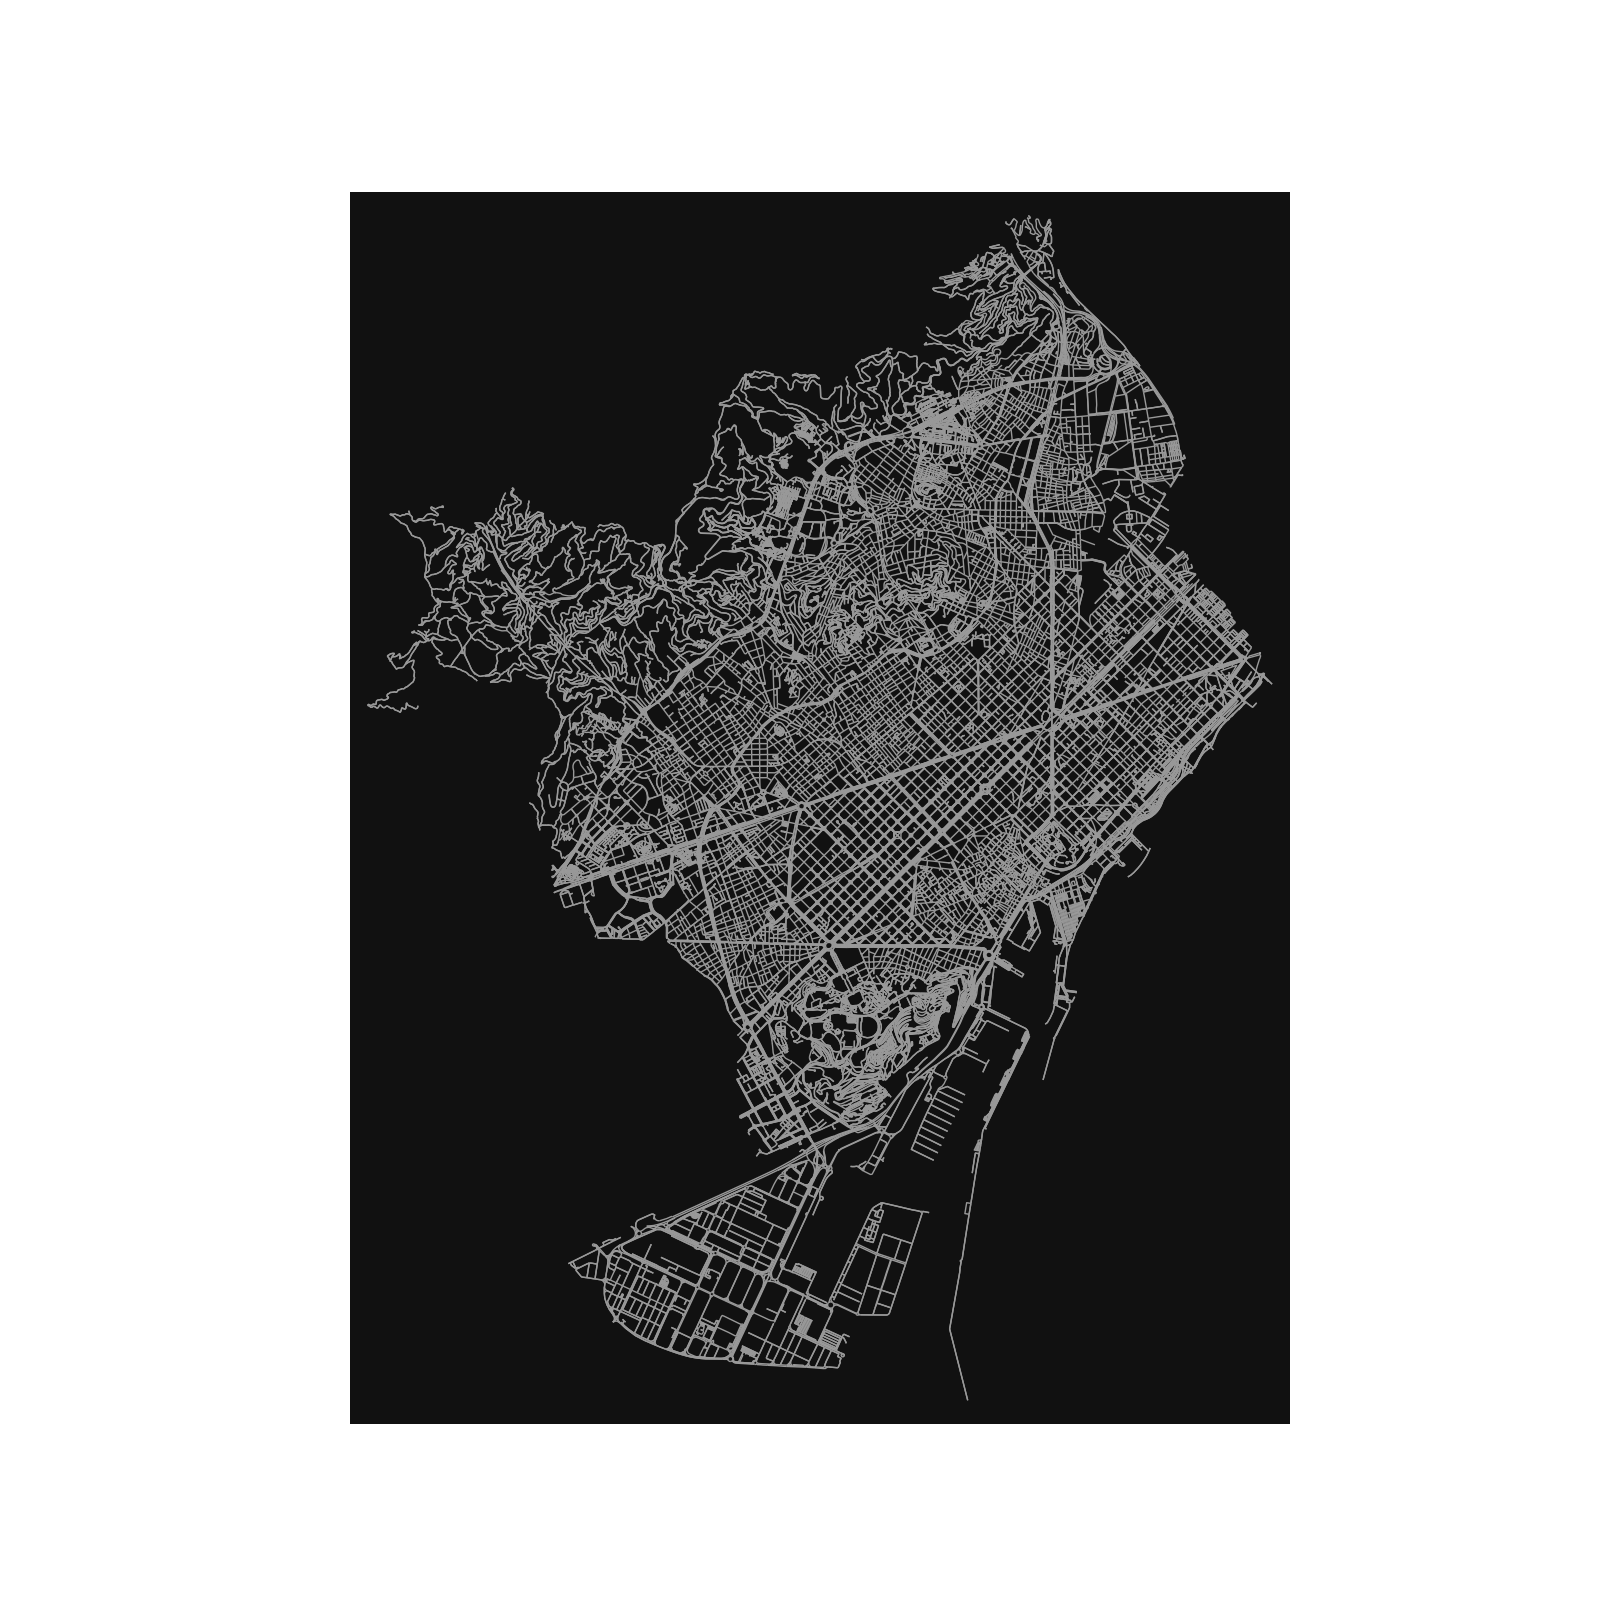

In [25]:
G = ox.graph_from_place('Barcelona, Spain', network_type='all')
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)

<IPython.core.display.Javascript object>


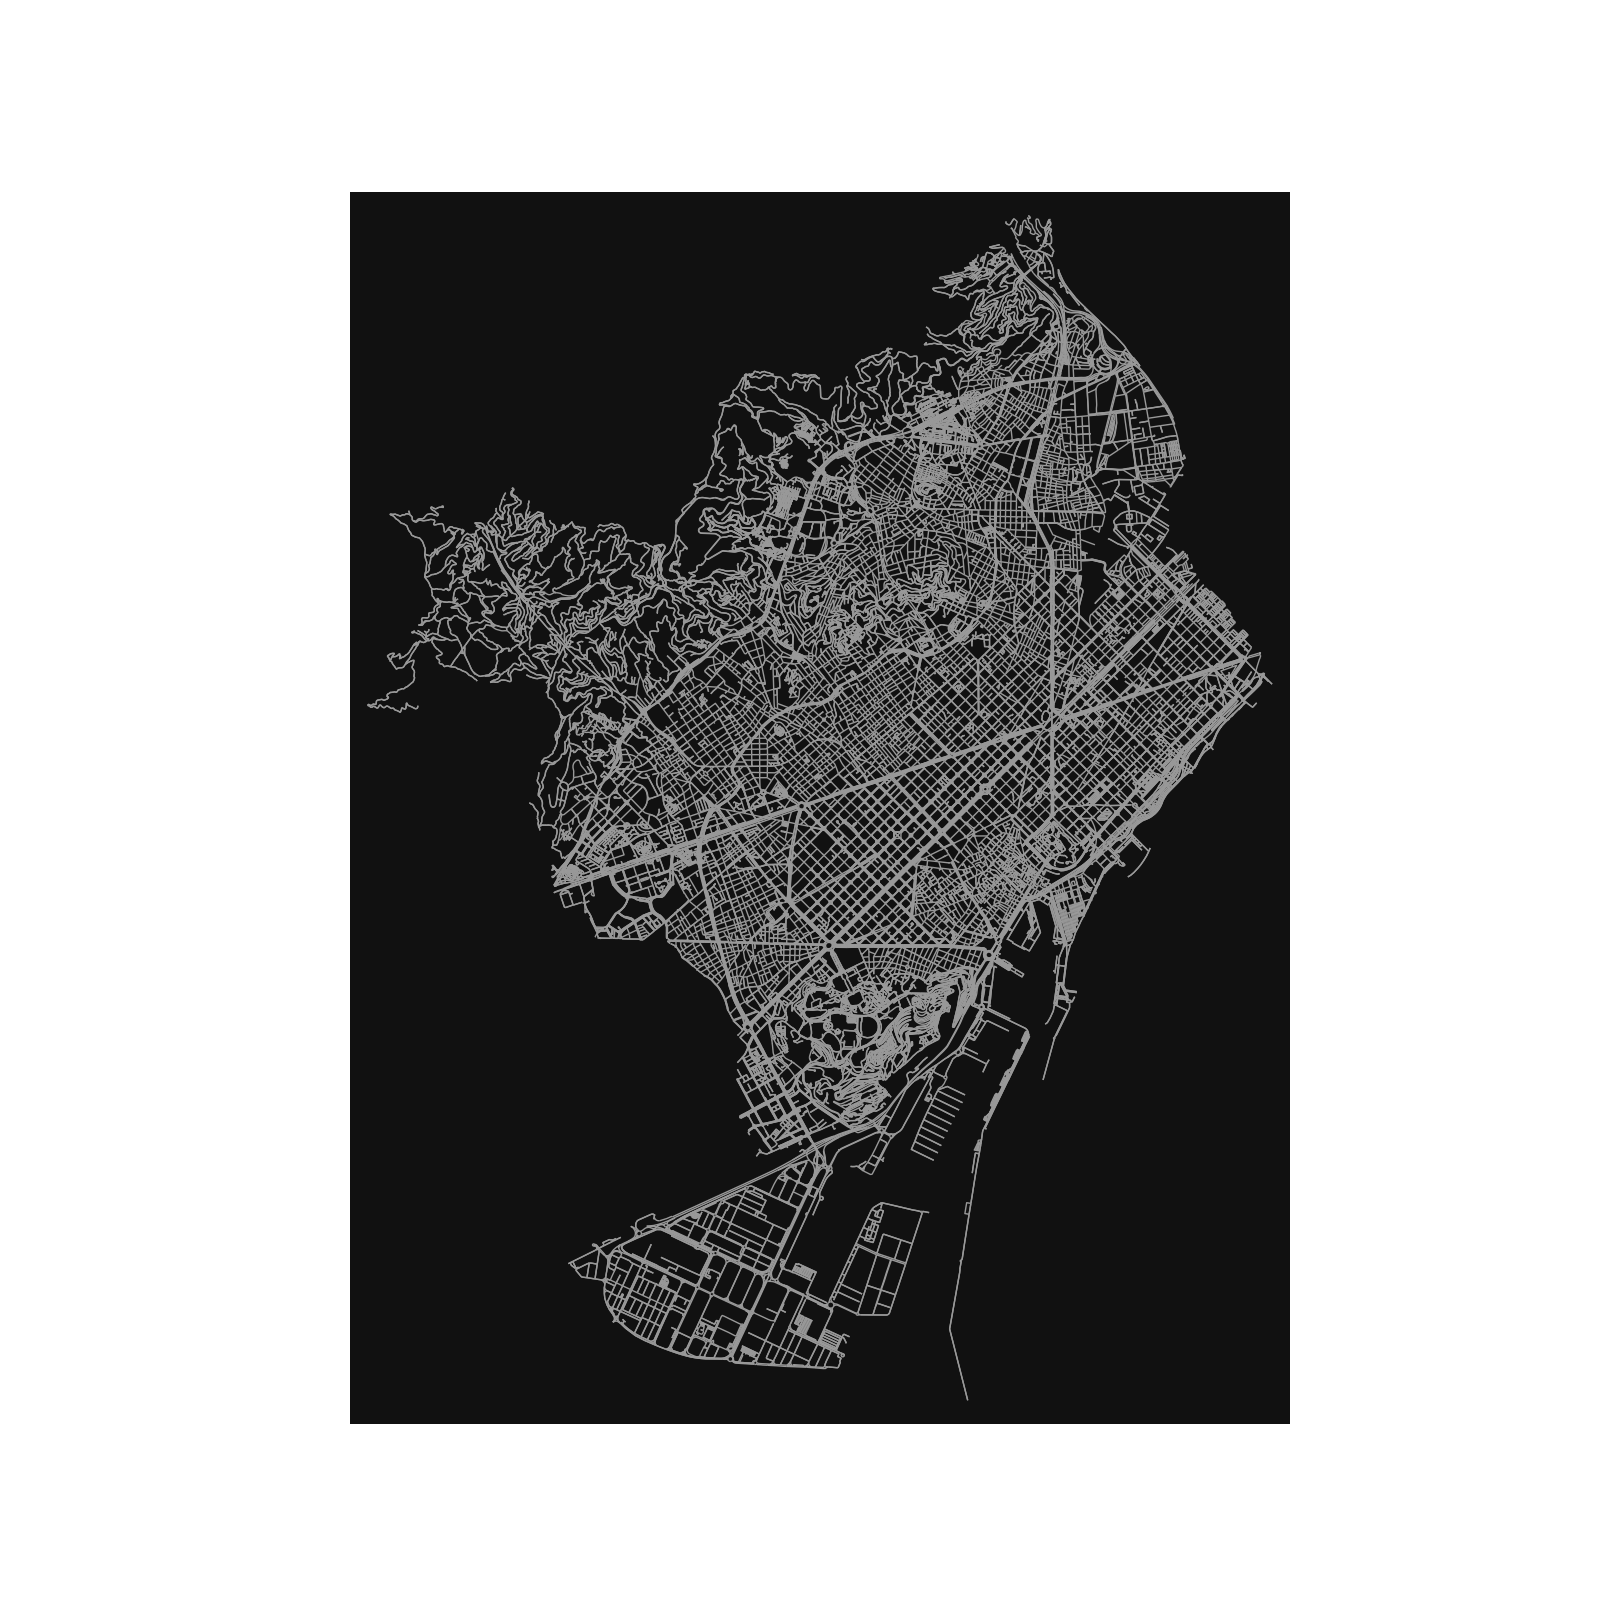

In [26]:
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)
nodes, streets = ox.graph_to_gdfs(G)

In [2]:
TRAFFIC_MAY_URL="geodata/2020_11_Novembre_TRAMS_TRANSIT.csv.gz"
STREETS_MAPPING_URL="geodata/transit_relacio_trams_fixed.csv"
STREETS_MAPPING_URL_LONG="geodata/transit_relacio_trams_format_long.csv"

In [3]:
trf = pd.read_csv(TRAFFIC_MAY_URL, sep=",")
# O - No Data
# 1 - Very Fluid
# 2 - Fluid
# 3 - Dense
# 4 - Very Dense
# 5 - Congestion
# 6 - Line closed

# clean trf 0, 6
trfs0, _ = trf.shape
trf = trf[
    ~(
        trf['estatActual'].isin([0, 6]) | trf['estatPrevist'].isin([0, 6])
    )
]
trfs1, _ = trf.shape
# print the amount of rows that were dropped
print(f"{trfs0 - trfs1} of {trfs0:,} rows were dropped ({(trfs0-trfs1)/trfs0:0%})")

trf["data_datetime"] = pd.to_datetime(trf["data"].astype(str), format='%Y%m%d%H%M%S')

trf.head(10)


streets = pd.read_csv(STREETS_MAPPING_URL, sep=",")

streets.head(10)

2515337 of 4,508,485 rows were dropped (55.791180%)


Tram                                    Descripció  \
0     1     Diagonal (Ronda de Dalt a Doctor Marañón)   
1     2     Diagonal (Doctor Marañón a Ronda de Dalt)   
2     3      Diagonal (Doctor Marañón a Pl. Pius XII)   
3     4      Diagonal (Pl. Pius XII a Doctor Marañón)   
4     5  Diagonal (Pl. Pius XII a Pl. Maria Cristina)   
5     6  Diagonal (Pl. Maria Cristina a Pl. Pius XII)   
6     7      Diagonal (Pl. Maria Cristina a Numància)   
7     8      Diagonal (Numància a Pl. Maria Cristina)   
8     9           Diagonal (Entença a Francesc Macià)   
9    10           Diagonal (Francesc Macià a Entença)   

                                         Coordenades  
0  2.11203535639414,41.3841912394771,2.1015028628...  
1  2.111944376806616,41.38446666680338,2.10159408...  
2  2.112093343037027,41.38422850920645,2.12264979...  
3  2.122592049318304,41.38719094189204,2.11196902...  
4  2.122657659295115,41.38694195794678,2.12755961...  
5  2.127445471496177,41.38841486943499,2.12260182...  
6  2.132701524574889,41.38946673844387,2.12754890...  
7  2.132462297581474,41.38967891982529,2.12746219...  
8  2.137322638833081,41.39061820620348,2.14394391...  
9  2.144060999786239,41.39265861540969,2.13711452...

In [4]:
def reshape_line(line: T.List[str], chunksize: int, fillvalue: int) -> T.Iterable[T.Tuple[float]]:
    args = [iter(float(el) for el in line)] * chunksize
    return zip_longest(*args, fillvalue=fillvalue)


In [9]:
coords_wkt = []
for _s in streets["Coordenades"].str.split(","):
    _res = reshape_line(_s, chunksize=2, fillvalue=None)
    coords_wkt.append(LineString(_res))

crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(streets, crs=crs, geometry=coords_wkt)

In [11]:
print("Starting merge...")
# merge both dataframes using the id of the tram as common column
_merged = trf.merge(streets, left_on="idTram", right_on="Tram")
# drop unnecesary columns and set the idTram
_merged = _merged.drop(columns=["data", "Tram", "Coordenades"])
print("Finished merge...")
_merged.info()
_merged.head(10)

gdf = gpd.GeoDataFrame(_merged, crs=crs, geometry=_merged["geometry"])


Starting merge...
Finished merge...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1869386 entries, 0 to 1869385
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   idTram         int64         
 1   estatActual    int64         
 2   estatPrevist   int64         
 3   data_datetime  datetime64[ns]
 4   Descripció     object        
 5   geometry       geometry      
dtypes: datetime64[ns](1), geometry(1), int64(3), object(1)
memory usage: 99.8+ MB


In [14]:
import branca

colorscale = branca.colormap.linear.viridis.scale(1, 5)
colorscale.caption="Tram usage level"


def style_function(feature):
    estat_actual = int(feature['properties']['estatActual']) or None
    return {
        'alpha': 0.5,
        'weight': 3,
        'color': '#black' if estat_actual is None else colorscale(estat_actual)
    }

# we will manipulate the dataframe to plot data using time scales, 
# since plotting the whole dataframe it's too expensive memory-wise

first_10_am = gdf[(gdf["data_datetime"].dt.day == 10) & (gdf["data_datetime"].dt.hour == 18)]

# we need to drop this column because it raises an error
first_10_am = first_10_am.drop(columns="data_datetime", inplace=False)

# plot the map
print("Plotting...")
barca_map_colors = folium.Map([41.3947,2.1557], zoom_start=12.4, tiles='cartodbpositron')

(
    folium.GeoJson(
        first_10_am,
        style_function=style_function)
    .add_to(barca_map_colors)
)

# add legend, see <https://github.com/python-visualization/folium/issues/528>
barca_map_colors.add_child(colorscale)

# plot map
barca_map_colors

Plotting...


/Users/mario/opt/anaconda3/envs/iper/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [15]:
# we will manipulate the dataframe to plot data using time scales

gdf_hourly = (
        # group by desired columns
        gdf.groupby(
            by=[gdf['idTram'],
                gdf["data_datetime"].dt.day, # here is where the grouping happens
               ],
            as_index=True)
        # show the mean of the aggregated values
        .mean()
        .reset_index()
)

gdf_hourly["diff_perc"] = gdf_hourly["estatActual"]/gdf_hourly["estatPrevist"]*100
gdf_hourly["was_forecast_right"] = gdf_hourly["diff_perc"] <= 100
gdf_hourly_w_geometry = gdf_hourly.merge(streets, left_on="idTram", right_on="Tram")
gdf_hourly_w_geometry.tail()

idTram  data_datetime  estatActual  estatPrevist   diff_perc  \
10898     534             26     1.920863      1.910072  100.564972   
10899     534             27     1.792727      1.792727  100.000000   
10900     534             28     1.249071      1.249071  100.000000   
10901     534             29     1.082090      1.085821   99.656357   
10902     534             30     2.169173      2.154135  100.698080   

       was_forecast_right  Tram                                   Descripció  \
10898               False   534  Ronda Litoral (Nus de la Trinitat a Potosí)   
10899                True   534  Ronda Litoral (Nus de la Trinitat a Potosí)   
10900                True   534  Ronda Litoral (Nus de la Trinitat a Potosí)   
10901                True   534  Ronda Litoral (Nus de la Trinitat a Potosí)   
10902               False   534  Ronda Litoral (Nus de la Trinitat a Potosí)   

                                             Coordenades  \
10898  2.206062333803802,41.44356616311283,2.20196194...   
10899  2.206062333803802,41.44356616311283,2.20196194...   
10900  2.206062333803802,41.44356616311283,2.20196194...   
10901  2.206062333803802,41.44356616311283,2.20196194...   
10902  2.206062333803802,41.44356616311283,2.20196194...   

                                                geometry  
10898  LINESTRING (2.20606 41.44357, 2.20196 41.44804...  
10899  LINESTRING (2.20606 41.44357, 2.20196 41.44804...  
10900  LINESTRING (2.20606 41.44357, 2.20196 41.44804...  
10901  LINESTRING (2.20606 41.44357, 2.20196 41.44804...  
10902  LINESTRING (2.20606 41.44357, 2.20196 41.44804...

In [16]:
import branca
from folium.plugins import Search
from geopandas import GeoDataFrame

# produce the geopandas dataframe
crs = {'init': 'epsg:4326'}
gdf_hourly = GeoDataFrame(
    gdf_hourly_w_geometry[gdf_hourly_w_geometry['data_datetime']==27], # here is where the filtering happens
    crs=crs,
    geometry=gdf_hourly_w_geometry['geometry']
)

# create colorscale
colorscale = branca.colormap.step.Accent_06.scale(1, 5)
colorscale.caption="estatActual (Daily average)"

# define a method for styling lines
def style_function_capacity(feature):
    not_exceeded = int(feature['properties']['was_forecast_right']) or None
    estat_actual = int(feature['properties']['estatActual']) or None
    
    # see for other options https://leafletjs.com/reference-1.5.0.html#path-option
    return {
        'alpha': 0.5,
        'dashArray': '5,10' if not_exceeded else '0', # dashed line unless forecast is wrong
        'weight': 3,
        'color': '#black' if estat_actual is None else colorscale(estat_actual),
    }
  
# plot the map of barcelona
hourly_map = folium.Map([41.3947,2.1557], zoom_start=12.4, tiles='cartodbpositron')

# plot the tram lines
tram_map = (
    folium.GeoJson(
        gdf_hourly,
        name="Barcelona Tram Capacity (27 May 2019)",
        style_function=style_function_capacity,
        tooltip=folium.GeoJsonTooltip(
            fields=['idTram', 'estatActual', 'estatPrevist', 'diff_perc', 'Descripció'],
            aliases=['Tram ID', 'Observed Capacity', 'Forecasted Capacity', 'Load (%)', 'Description'], 
            localize=True)
    )
    .add_to(hourly_map)
)

# add legend, see <https://github.com/python-visualization/folium/issues/528>
hourly_map.add_child(colorscale)

# add a searchbox bound to the Description of lines
statesearch = Search(
    layer=tram_map,
    geom_type='Line',
    placeholder='Search for a Tram Description',
    collapsed=False,
    search_label='Descripció',
    weight=3
).add_to(hourly_map)


# plot map
hourly_map

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.